# CSCK507 Mid Module - Toxic Comment Classification Challenge

## Table of Contents
[Section 1. Introduction](#introduction)
- [Import Dependencies](#import-dependencies)
- [Loading Kaggle dataset into DataFrame](#import-dependencies)
- [Initialise SpaCy Model ](#import-dependencies)

[Section 2. Data Exploration & Analysis](#data-exploration-&-analysis)
- [2.1 Data Preparation and Preprocessing](#data-exploration-&-analysis)
    - [2.1.1 Dataset Alignment](#data-preprocessing)
    - [2.1.2 Text Preprocessing](#data-preprocessing)
    - [2.1.3 Tokenisation and Lemmatisation](#data-preprocessing)
    - [2.1.4 Combining Tokenised Features and Labels for Training and Test Dataset](#data-preprocessing)
- [2.2 Data Analysis Requirements](#data-exploration-&-analysis)
    - [2.2.1 Number of Sentences & Tokens Per Class](#data-preprocessing)
    - [2.2.2 Data Imbalance](#data-imbalance)
    - [2.2.3 Understanding the Most Common Words](#data-preprocessing)
    - [2.2.4 Data Analysis Summary](#data-imbalance)
    
[Section 3. Machine Learning Model Development](#data-exploration-&-analysis)
- [3.1 Feature Extraction Methods](#data-preprocessing)
    - [3.1.1 TF-IDF Implementation](#data-preprocessing)
    - [3.1.2 Word Embedding through Word2Vec](#data-preprocessing)
- [3.2 Model Selection & Training](#data-exploration-&-analysis)
    - [3.2.1 Logistic Regression](#data-preprocessing)
    - [3.2.2 Support Vector Machine](#data-preprocessing)
    - [3.2.3 Multinomial Naive Bayes](#data-preprocessing)


[Section 4. Evaluation of Selected Models](#data-exploration-&-analysis)
- [4.1 Feature Extraction Methods](#data-preprocessing)



---
## Section 1. Introduction

Originating in 2018, this challenge revolves around classifying different levels of toxicity in online comments. The dataset from the inaugural competition is utilized to analyze and evaluate the performance of various machine learning algorithms in categorizing six types of toxicity. The primary goal is not only to find an optimal solution but to understand the process of evaluating machine learning algorithms' performance in a classification task. This individual assessment involves data analysis, algorithm selection, and the exploration of feature extraction methods to uncover insights into the nuances of toxic comment classification.

The Toxic Comment Classification Challenge and dataset can be obtained here: [Kaggle Challenge](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data)

### Importing Dependencies

In [1]:
# General
import os
import pandas as pd 
import numpy as np

# Data Preprocessing
import re  
import nltk
from nltk.corpus import stopwords

# Feature Extraction  
import dill
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.base import TransformerMixin

# Machine Learning
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                             f1_score,multilabel_confusion_matrix, 
                             precision_score,recall_score, roc_auc_score)

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Warning Handling
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

### Load Kaggle dataset into DataFrame

In [2]:
df = pd.read_csv('dataset/train.csv')
df_test_labels = pd.read_csv('dataset/test_labels.csv')
df_test_comment = pd.read_csv('dataset/test.csv')

### Initialise SpaCy Model 

In [3]:
try:
    spacy.prefer_gpu()
    nlp = spacy.load('en_core_web_sm')
except (LookupError, OSError):
    print('Run: python -m spacy download en_core_web_sm')

try:
    nltk_stop = stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
    nltk_stop = stopwords.words('english')

---
## Section 2. Data Exploration & Analysis

In [4]:
df.sample(10).head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
10108,1abb94c6502ac143,The picture on the article is not of the actor...,0,0,0,0,0,0
100849,1bbd67763b532b47,"""\n\nand dont forget a certain """"mr. c"""" who w...",0,0,0,0,0,0
43801,74e8643075586e2c,Miners Day \n\nThanks for deleting it fuck bag...,1,0,1,1,1,0
79712,d545e547a182f55f,about English \n\nhey Athenean \nfrom turkey w...,0,0,0,0,0,0
96482,040d899b80974933,or are in need of assistance,0,0,0,0,0,0
59432,9f324bc1285e0ba8,They fixed it \n\nWhat the Chiz!!! Man. Dude t...,0,0,0,0,0,0
96118,022f3512ecd08560,FUCK YOU RORY. YOU ARE A CUMSLURPING COCKLOVER.,1,0,1,0,1,0
93409,f9bc5cd65e6adf5c,shebaa frams reversion \n\nI have undone your ...,0,0,0,0,0,0
89270,eec837d78c760cc5,Ask yourself a question: What does a random ph...,0,0,0,0,0,0
7793,14bbd339caae916c,VPC promotions \n\nI have never promoted pictu...,0,0,0,0,0,0


In [5]:
df.info()
print("The table dimensions are:",df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB
The table dimensions are: (159571, 8)


In [6]:
print(df.loc[30566])

id                                                5125ff19698165c6
comment_text     "\n\n""I think we should kill all the jews and...
toxic                                                            1
severe_toxic                                                     0
obscene                                                          0
threat                                                           1
insult                                                           1
identity_hate                                                    1
Name: 30566, dtype: object


As shown above, this task necessitates a multi-label classification approach for a more accurate understanding and identification of hate comments as they typically exhibit a nuanced interplay of multiple labels. 

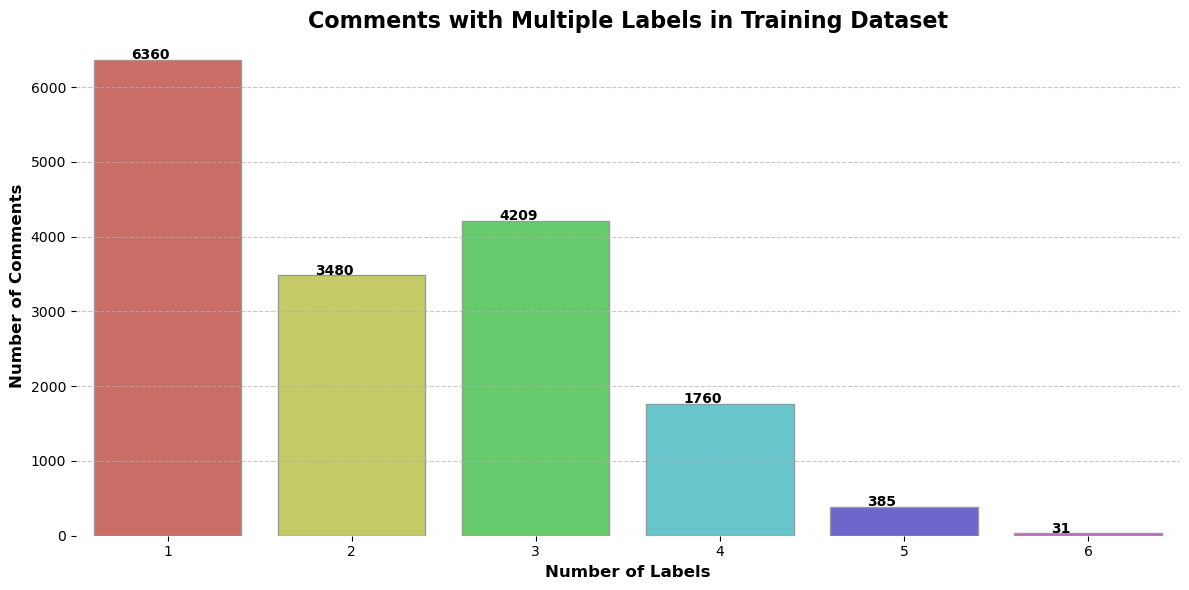

In [7]:
def plot_multilabel_count(df, title, offset=10):
    row_sums = df.iloc[:, 2:].sum(axis=1)
    label_counts = row_sums.value_counts().sort_index(ascending=True)[1:]

    plt.figure(figsize=(12, 6))
    sns.barplot(x=label_counts.index, y=label_counts.values, palette="hls", edgecolor=".6")
    
    for i, v in enumerate(label_counts.values):
        plt.text(i - 0.2, v + offset, str(v), color='black', fontweight='bold')

    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Number of Labels', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Comments', fontsize=12, fontweight='bold')
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()

# Plot number of comments with multiple labels
plot_multilabel_count(df, 'Comments with Multiple Labels in Training Dataset')

### Dataset Alignment

In [8]:
try:
    class_labels = list(df.columns[2:])
    print("Class labels extracted.")

    # Remove rows with -1 from 'df_test' since they are not used for scoring
    print(f'df_test before removing -1: {df_test_labels.shape}')
    
    for class_label in class_labels:
        df_test_labels = df_test_labels[df_test_labels[class_label] != -1]
    print(f'df_test after removing -1: {df_test_labels.shape}')

    # Left join 'df_test' and 'df_test_comment' on the 'id' column
    df_test = pd.merge(df_test_labels, df_test_comment, on='id', how='left')

    # Create a new DataFrame called 'df_test' and match the column structure of 'df'
    df_test = df_test[['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
    print("New DataFrame 'df_test' created.")

except KeyError as ke:
    print(f"Error: {ke} not found.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Class labels extracted.
df_test before removing -1: (153164, 7)
df_test after removing -1: (63978, 7)
New DataFrame 'df_test' created.


### Data Preprocessing, Tokenisation, and Lemmatisation

The preprocessing step plays a critical role in cleansing and standardising textual data for manageability purposes. This stage typically consists of tasks, such as:

- Removing URLs, extra spaces, and non-English characters
- Trimming start and end white spaces
- Eliminating leading and trailing spaces and quotation marks
- Discarding single characters
- Eliminating punctuation without converting to lowercase

**Note:** An area worth noting for hate speech detection is that preserving the original case is essential, as individuals expressing anger may resort to typing in all caps, and ignoring case distinctions would hinder the effectiveness of the model. As such, it is not performed below in the preprocessing stage.

In [9]:
def preprocess_text(text, nltk_stop=None):
    try:
        if nltk_stop is None:
            nltk_stop = set(stopwords.words('english'))
    except LookupError:
        print("NLTK stopwords not available. Consider downloading with nltk.download('stopwords').")

    try:
        # Combine URL removal, extra space replacement, and Non-English characters removal
        text = re.sub(r"(http\S+|www\S+|https\S+)|[^\x00-\x7F]+", " ", text)
        # Remove start and end white spaces
        text = text.strip()
        # Remove leading and trailing spaces and quotation marks
        text = text.strip('"')
        # Remove single characters
        text = re.sub(r"\s+[a-zA-Z]\s+", " ", text)
        # Remove punctuations.
        text = re.sub(r"[^a-zA-Z0-9]+", " ", text)
        # Stopword Removal using set operations
        text = ' '.join(set(text.split()) - nltk_stop)

        return text

    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

### Tokenisation and Lemmatisation

In [10]:
def tokenize_lemma_text(documents):
    """
    Tokenize a list of documents and perform the following:
    1. Break text into individual words or subword tokens.
    2. Reduce words to their base or root form using lemmatization.
    3. Remove stop words and non-alphabetic characters.

    Utilises spaCy's nlp.pipe for efficient batch processing.

    :param documents: List of strings representing documents.
    :return: List of lists of strings, where each list corresponds to the lemmatized tokens of a document.
    """
    lemmatized_tokens_list = []
    
    # Process documents using spaCy's nlp.pipe with 'NER' and 'Parser' components disabled utilising 4 core parallel processing:
    for doc in nlp.pipe(documents, disable=["ner", "parser"], batch_size=5000, n_process=4):
        lemmatized_tokens = [token.lemma_ for token in doc if token.is_alpha and token.lemma_ not in nlp.Defaults.stop_words]
        lemmatized_tokens_list.append(lemmatized_tokens)

    return lemmatized_tokens_list

In many tokenisation tasks, especially those emphasizing lemmatisation and stop word removal, the additional linguistic information provided by the 'NER' and 'Parser' components is often unnecessary. 

**Disabling** these components during the processing of documents using 'nlp.pipe' can substantially reduce computational load and significantly improve efficiency and speed. This is particularly crucial when dealing with extensive amounts of text data, presenting a trade-off between computational resources and the need for specific linguistic information tailored to the task.

**Note:** A critical facet worth discussing is that while SpaCy conveniently handles all aspects performed in the 'preprocess_text' function regarding URL removal, whitespace trimming, stopword removal, etc. The linguistic analysis performed by SpaCy introduces overhead, making it relatively slower for simple tasks compared to a more lightweight solution like RegEx.

In [11]:
# Preprocess the train dataset
df['comment_text'] = df['comment_text'].apply(preprocess_text)
print("Preprocessed training dataset:")

Preprocessed training dataset:


In [12]:
#Display random rows from the training set
random_rows_train = df.sample(n=10) 
display(random_rows_train)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
142849,fbfcc36b0a5d41af,traditions definitive core They around pride u...,0,0,0,0,0,0
140847,f1b634bb9138be81,need Thank much believe adopter get co,0,0,0,0,0,0
146095,26e626115b694c5c,179 Wilson shipments 157 cadaver code Airlines...,0,0,0,0,0,0
113450,5eb3f65bb2e584ea,Pepper spend enough RL book makes take article...,0,0,0,0,0,0
138840,e6f2cf0a2868deed,13th message Yeah As cheers album comes said,0,0,0,0,0,0
64402,ac5d26faa6f7c4d0,say If It The precisely equivalent IS solution...,0,0,0,0,0,0
18109,2fd9c3c4315a7fd8,someone disruption If We high take try biased ...,0,0,0,0,0,0
113141,5cfee2fca1c2018c,And defender Link saw work club Also It Miami ...,0,0,0,0,0,0
50410,86c90e6e620f5a32,socketpuppets Else For It seems User step sinc...,0,0,0,0,0,0
60969,a33daee6243ef055,choose If Yes Also It The serious hundreds dep...,0,0,0,0,0,0


In [13]:
# Preprocess the test dataset
df_test['comment_text'] = df_test['comment_text'].apply(preprocess_text)

In [14]:
# Tokenizing the train and test datasets
tokenized_comment_train = tokenize_lemma_text(df['comment_text'].tolist())
tokenized_comment_test = tokenize_lemma_text(df_test['comment_text'].tolist())

In [15]:
# Get labels for train and test data
y_train = df[class_labels]
y_test = df_test[class_labels]

### Combining Tokenised Text Features & Labels for Training and Test Dataset

In [16]:
# Training data
df_train = pd.DataFrame({
    'comment_text': tokenized_comment_train,          # Tokenised comment text
    'toxic': y_train['toxic'],                        # Toxicity label
    'severe_toxic': y_train['severe_toxic'],          # Severe toxicity label
    'obscene': y_train['obscene'],                    # Obscenity label
    'threat': y_train['threat'],                      # Threatening language label
    'insult': y_train['insult'],                      # Insult label
    'identity_hate': y_train['identity_hate']         # Identity hate label
})

display(df_train.head())
print("The train dataset dimensions are:",df.shape)

# Test data
df_test = pd.DataFrame({
    'comment_text': tokenized_comment_test,     # Tokenised comment text for testing
    'toxic': y_test['toxic'],                   # Toxicity label for testing
    'severe_toxic': y_test['severe_toxic'],     # Severe toxicity label for testing
    'obscene': y_test['obscene'],               # Obscenity label for testing
    'threat': y_test['threat'],                 # Threatening language label for testing
    'insult': y_test['insult'],                 # Insult label for testing
    'identity_hate': y_test['identity_hate']    # Identity hate label for testing
})

display(df_test.head())
print("The test dataset dimensions are:",df_test.shape)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,"[Fan, FAC, retire, Dolls, gas, edit, closure, ...",0,0,0,0,0,0
1,"[D, match, colour, Thanks, aww, UTC, seemingly...",0,0,0,0,0,0
2,"[remove, instead, care, hey, edit, info, war, ...",0,0,0,0,0,0
3,"[nomination, exact, style, review, guess, date...",0,0,0,0,0,0
4,"[sir, chance, remember, page, hero]",0,0,0,0,0,0


The train dataset dimensions are: (159571, 8)


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,"[discussion, understand, thank, think, revert,...",0,0,0,0,0,0
1,"[horrible, god, site, Dear]",0,0,0,0,0,0
2,"[non, Really, Oz, try, acknowledgement, bother...",0,0,0,0,0,0
3,"[stop, center, Colleges, University, Albany, c...",0,0,0,0,0,0
4,"[reader, list, prove, add, revision, article, ...",0,0,0,0,0,0


The test dataset dimensions are: (63978, 7)


### 2.1 Requirements of Task 1

**Number of Sentences and Tokens**
- Analyze the number of sentences and tokens per class
- Check if the dataset is unbalanced or not

**Most Common Words Analysis**
- Examine the most common words for each class.

### Counting Number of Sentences & Tokens Per Class

In [17]:
import pandas as pd

class_counts = {'class_label': [], 'num_sentences': [], 'num_tokens': []}

for class_label in class_labels:
    class_comments = df_train[df_train[class_label] == 1]['comment_text'].tolist()

    total_sentences = 0
    total_tokens = 0

    for comment in class_comments:
        # Join the list of comments into a single string
        comment_text = " ".join(comment)

        # Count the number of sentences in the comment
        sentences = comment_text.split('.')
        total_sentences += len(sentences)

        # Count the number of tokens in the comment
        tokens = comment_text.split()
        total_tokens += len(tokens)

    class_counts['class_label'].append(class_label)
    class_counts['num_sentences'].append(total_sentences)
    class_counts['num_tokens'].append(total_tokens)
    
class_counts_df = pd.DataFrame(class_counts)

print(class_counts_df)

     class_label  num_sentences  num_tokens
0          toxic          15294      244383
1   severe_toxic           1595       19351
2        obscene           8449      126595
3         threat            478        6871
4         insult           7877      115186
5  identity_hate           1405       21895


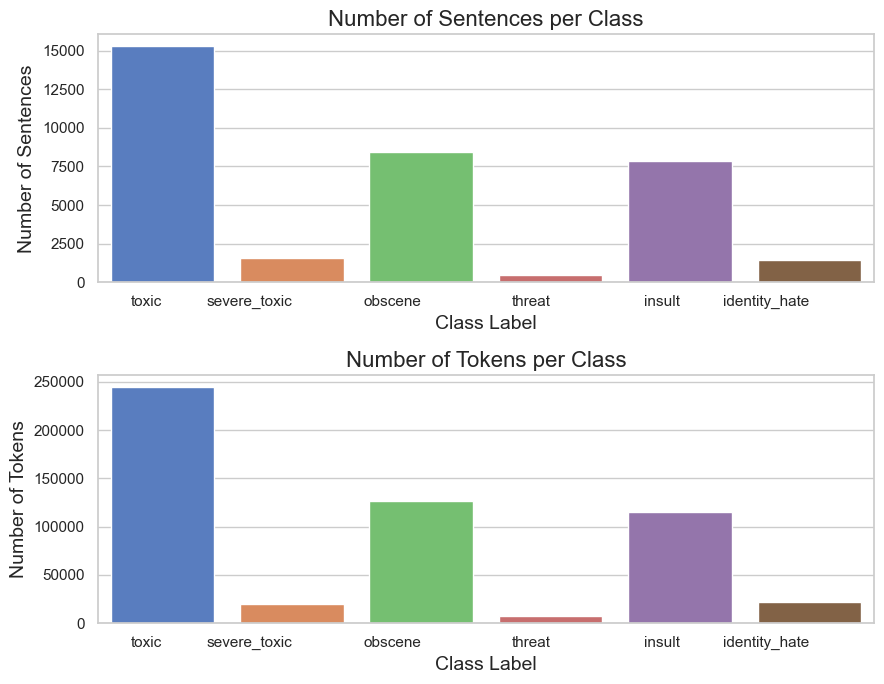

In [18]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 1, figsize=(9, 7))

# Plot the number of sentences per class
sentences_plot = sns.barplot(
    ax=axes[0],
    x='class_label',
    y='num_sentences',
    data=class_counts_df,
    palette="muted"
)
sentences_plot.set_title('Number of Sentences per Class', fontsize=16)
sentences_plot.set_xlabel('Class Label', fontsize=14)
sentences_plot.set_ylabel('Number of Sentences', fontsize=14)
sentences_plot.set_xticklabels(sentences_plot.get_xticklabels(), ha='right') 

# Plot the number of tokens per class
tokens_plot = sns.barplot(
    ax=axes[1],
    x='class_label',
    y='num_tokens',
    data=class_counts_df,
    palette="muted"
)
tokens_plot.set_title('Number of Tokens per Class', fontsize=16)
tokens_plot.set_xlabel('Class Label', fontsize=14)
tokens_plot.set_ylabel('Number of Tokens', fontsize=14)
tokens_plot.set_xticklabels(tokens_plot.get_xticklabels(), ha='right')  

plt.tight_layout() 
plt.show()

warnings.filterwarnings(action='ignore')

### Understanding the Most Common Words in Training Data

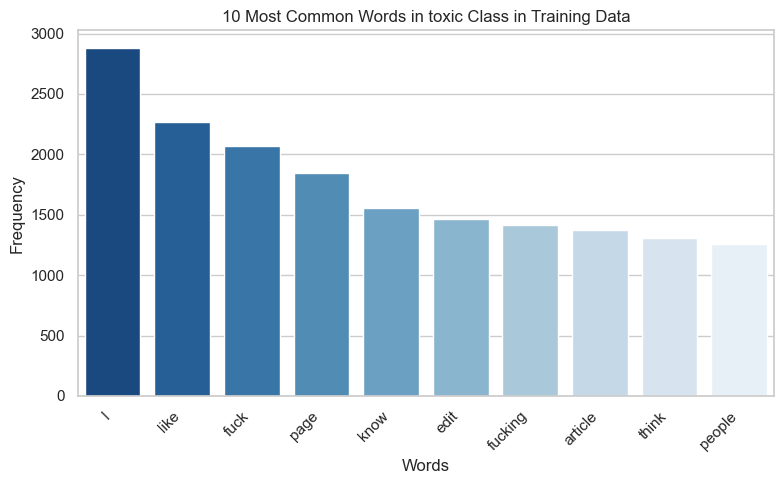

Most common words in toxic class: [('I', 2882), ('like', 2265), ('fuck', 2072), ('page', 1847), ('know', 1553), ('edit', 1468), ('fucking', 1418), ('article', 1376), ('think', 1309), ('people', 1258)]


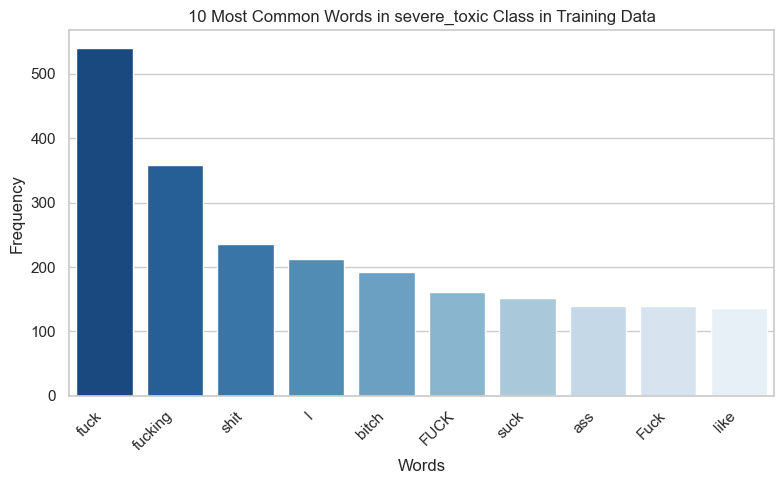

Most common words in severe_toxic class: [('fuck', 540), ('fucking', 359), ('shit', 235), ('I', 213), ('bitch', 192), ('FUCK', 162), ('suck', 152), ('ass', 140), ('Fuck', 139), ('like', 136)]


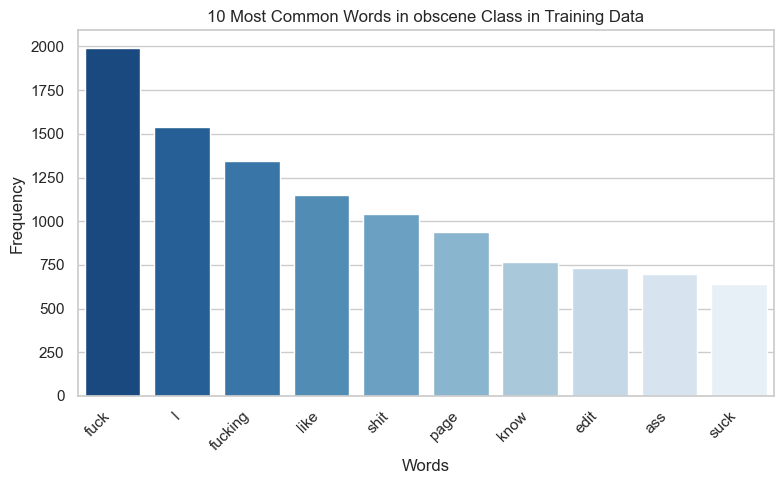

Most common words in obscene class: [('fuck', 1992), ('I', 1540), ('fucking', 1346), ('like', 1152), ('shit', 1042), ('page', 937), ('know', 768), ('edit', 735), ('ass', 697), ('suck', 641)]


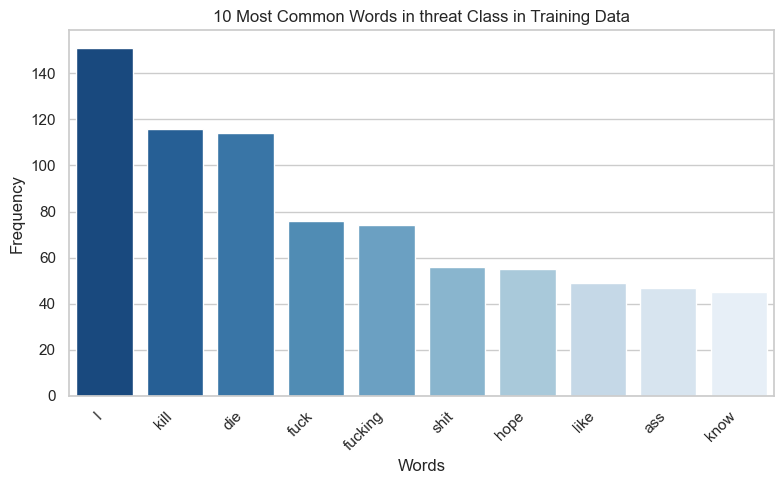

Most common words in threat class: [('I', 151), ('kill', 116), ('die', 114), ('fuck', 76), ('fucking', 74), ('shit', 56), ('hope', 55), ('like', 49), ('ass', 47), ('know', 45)]


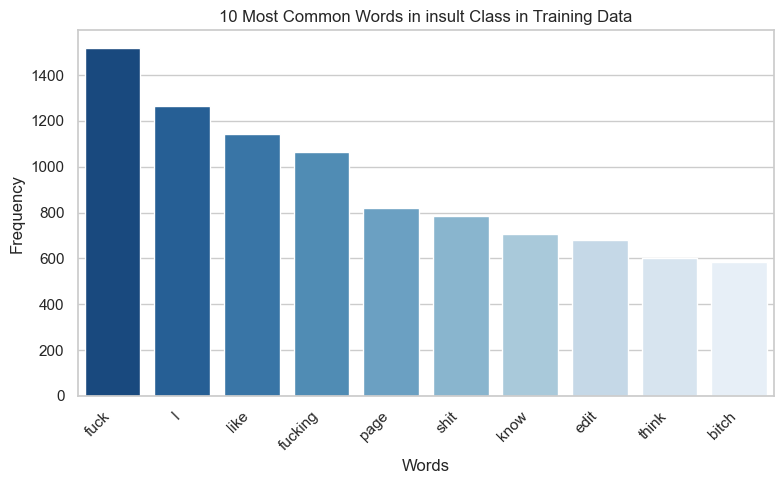

Most common words in insult class: [('fuck', 1519), ('I', 1263), ('like', 1141), ('fucking', 1063), ('page', 819), ('shit', 786), ('know', 705), ('edit', 681), ('think', 604), ('bitch', 584)]


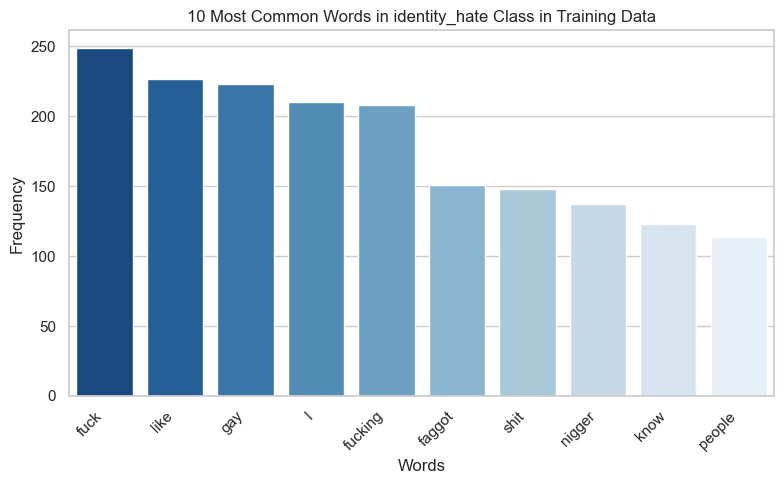

Most common words in identity_hate class: [('fuck', 249), ('like', 227), ('gay', 223), ('I', 210), ('fucking', 208), ('faggot', 151), ('shit', 148), ('nigger', 137), ('know', 123), ('people', 114)]


In [19]:
def plot_common_words(counts, title):
    labels = [word for word, _ in counts]
    freqs = [count for _, count in counts]

    plt.figure(figsize=(8, 5))
    sns.barplot(x=labels, y=freqs, palette="Blues_r")  
    
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')  
    plt.tight_layout()  
    plt.show()

for label in class_labels:
    words = []
    for comment in df_train[df_train[label] == 1]['comment_text']:
        words.extend(comment)
    
    most_common_words = Counter(words).most_common(10)
    
    # Plot and display the 10 most common words
    plot_common_words(most_common_words, f'10 Most Common Words in {label} Class in Training Data')
    
    print(f'Most common words in {label} class: {most_common_words}')

warnings.filterwarnings(action='ignore')

### Exploring Class Distribution and Imbalance 

In [20]:
class_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

total_samples = len(df)

for column in class_columns:
    # Count the occurrences of each class label
    class_counts = df[column].value_counts()
    
    # Print the counts and percentages for each class label
    print(f"{column.capitalize()} Counts:")
    for index, count in class_counts.items():
        # Determine the class label (Non-<class_label> for index 0, <class_label> otherwise)
        class_label = "Non-" + column if index == 0 else column
        # Calculate the percentage of samples for the current class label
        percentage = (count / total_samples) * 100
        # Print count and percentage for each class label
        print(f"{class_label}: {count} ({percentage:.2f}%)")
    
    # Print a separator line between class labels
    print(f"\n{'='*30}\n")
    

Toxic Counts:
Non-toxic: 144277 (90.42%)
toxic: 15294 (9.58%)


Severe_toxic Counts:
Non-severe_toxic: 157976 (99.00%)
severe_toxic: 1595 (1.00%)


Obscene Counts:
Non-obscene: 151122 (94.71%)
obscene: 8449 (5.29%)


Threat Counts:
Non-threat: 159093 (99.70%)
threat: 478 (0.30%)


Insult Counts:
Non-insult: 151694 (95.06%)
insult: 7877 (4.94%)


Identity_hate Counts:
Non-identity_hate: 158166 (99.12%)
identity_hate: 1405 (0.88%)




Looking at the results, it's clear that there's a big difference in the number of non-hateful and hateful instances in the datasets.

To tackle this imbalance during training, we decided to use class weights instead of changing the data. Class weights are figured out by taking the inverse of how often each class appears in the training data. Here's the formula we used:

class weight = 1/class frequency

Because of the noticeable imbalance in our data, it's suggested to rethink using accuracy as the main way to measure how well the model is doing. It's better to consider alternatives like precision, recall, or the area under the receiver operating characteristic curve (AUC).

Following the competition's guidelines, we've chosen to use ROC-AUC as the main way to evaluate our models. This metric gives a thorough look at how well the model performs across different classification thresholds. It helps us better understand how good the model is at distinguishing between classes, especially when the data is imbalanced.

---
## Section 3. Feature Extraction

### TF-IDF Implementation

TF-IDF weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

**TF:** Term Frequency, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization:

**TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).**

**IDF:** Inverse Document Frequency, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following:

**Formula:** IDF(t) = log_e(Total number of documents / Number of documents with term t in it).

In [21]:
# Save the TF-IDF vectorizer
def save_tfidf_vectorizer(vectorizer, filename):
    try:
        with open(filename, 'wb') as f:
            dill.dump(vectorizer, f)
    except Exception as e:
        print(f"Error saving TF-IDF vectorizer: {e}")

# Load the TF-IDF vectorizer if it exists, otherwise return None
def load_tfidf_vectorizer(filename):
    try:
        if os.path.exists(filename):
            with open(filename, 'rb') as f:
                return dill.load(f)
    except Exception as e:
        print(f"Error loading TF-IDF vectorizer: {e}")
    return None

# Create function to compute TF-IDF features
def compute_tfidf_features(vectorizer, train_data, test_data):
    X_train_tfidf = vectorizer.fit_transform(train_data)
    X_test_tfidf = vectorizer.transform(test_data)
    return X_train_tfidf, X_test_tfidf

tfidf_vectorizer_filename = 'model/tfidf_vectorizer.dill'

# Load or create and save the TF-IDF vectorizer
tfidf_vectorizer = load_tfidf_vectorizer(tfidf_vectorizer_filename)

if tfidf_vectorizer is None:
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=75_000, tokenizer=lambda x: x, preprocessor=lambda x: x)
    save_tfidf_vectorizer(tfidf_vectorizer, tfidf_vectorizer_filename)

# Call the 'compute_tfidf_features' function for the training and test features
X_train_tfidf, X_test_tfidf = compute_tfidf_features(tfidf_vectorizer, df_train['comment_text'], df_test['comment_text'])

# Extract class labels
y_train_tfidf = df_train[class_labels]
y_test_tfidf = df_test[class_labels]

In [22]:
print("TF-IDF Information:")
print(f"Training TF-IDF Features Shape: {X_train_tfidf.shape}")
print(f"Training Labels Shape: {y_train.shape}")
print(f"Testing TF-IDF Features Shape: {X_test_tfidf.shape}")
print(f"Testing Labels Shape: {y_test.shape}")

TF-IDF Information:
Training TF-IDF Features Shape: (159571, 75000)
Training Labels Shape: (159571, 6)
Testing TF-IDF Features Shape: (63978, 75000)
Testing Labels Shape: (63978, 6)


### Word Embedding

Word2Vec excels in capturing semantic relationships, providing context-aware representations, and offering transferable features. It aims to learn distributed representations (embeddings) of words in a continuous vector space, capturing semantic relationships and contextual information.

In [36]:
# Function to load Word2Vec model
def load_word2vec_model(filename):
    if os.path.exists(filename):
        return Word2Vec.load(filename)
    else:
        return None

# Function to save Word2Vec model
def save_word2vec_model(model, filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    model.save(filename)

# Custom transformer class for Word2Vec
class Word2VecVectorizer(TransformerMixin):
    def __init__(self, word2vec_model):
        self.word2vec_model = word2vec_model

    def fit(self, X, y=None):
        # No fitting needed for Word2Vec
        return self

    def transform(self, X):
        return [self.get_document_vector(doc) for doc in X]

    def get_document_vector(self, document):
        document_vector = np.zeros(self.word2vec_model.vector_size)
        n_words = 0
        for word in document:
            if word in self.word2vec_model.wv:
                document_vector += self.word2vec_model.wv[word]
                n_words += 1
        if n_words > 0:
            document_vector /= n_words

        # Min-Max scaling to handle negative vectors
        min_val = np.min(document_vector)
        max_val = np.max(document_vector)
        document_vector = (document_vector - min_val) / (max_val - min_val) if (max_val - min_val) != 0 else document_vector

        return document_vector

# Instantiate or load the Word2Vec model
word2vec_model_filename = './word2vec_model'
word2vec_model = load_word2vec_model(word2vec_model_filename)

if word2vec_model is None:
    # Similarly, the tokenized text is used as input for the Word2Vec model
    word2vec_model = Word2Vec(sentences=df_train['comment_text'], vector_size=100, window=5, min_count=1, workers=4)
    save_word2vec_model(word2vec_model, word2vec_model_filename)

# Calling the 'transform' method of Word2VecVectorizer for the training and test features
word2vec_vectorizer = Word2VecVectorizer(word2vec_model)
X_train_word2vec = word2vec_vectorizer.transform(df_train['comment_text'])
X_test_word2vec = word2vec_vectorizer.transform(df_test['comment_text'])

# Extract class labels
y_train_word2vec = df_train[class_labels]
y_test_word2vec = df_test[class_labels]


In [24]:
print("Word2Vec Information:")
print(f"Training Word2Vec Features Length: {len(X_train_word2vec)}")
print(f"Training Labels (Word2Vec) Shape: {y_train_word2vec.shape}")
print(f"Testing Word2Vec Features Length: {len(X_test_word2vec)}")
print(f"Testing Labels (Word2Vec) Shape: {y_test_word2vec.shape}")

Word2Vec Information:
Training Word2Vec Features Length: 159571
Training Labels (Word2Vec) Shape: (159571, 6)
Testing Word2Vec Features Length: 63978
Testing Labels (Word2Vec) Shape: (63978, 6)


**Note:** Saving the TF-IDF and Word2Vec models are common practice in ML workflow, allowing for:

- Reusability: Models can be shared and reused in various projects, fostering collaboration and saving time/resources.

- Scalability: Pre-trained models facilitate scalability for large datasets, avoiding the need for retraining and reducing computational costs.

- Consistency: Saved models ensure a consistent representation, maintaining uniformity across development and deployment phases.

### TF-IDF vs Word2Vec

Both TF-IDF and Word2Vec are powerful tools used in language processing. TF-IDF is straightforward, giving importance to words based on how often they appear in a document compared to a larger collection of documents. It works well when there's not a lot of data but doesn't grasp the meaning of words and represents documents in a fixed way.

On the flip side, Word2Vec is better at understanding the meaning of words and their relationships. It considers the context in which words appear and can measure how similar words are. However, it needs a good amount of data to work effectively.

In the context of hate speech, TF-IDF might flag problematic documents based on rare negative words, while Word2Vec could better capture the semantic nuances, recognising negative sentiments and similarities between phrases with similar meanings. Nevertheless, both methods alone may not comprehensively detect hate speech, and more advanced techniques, such as deep learning models with contextual embeddings, may be necessary for robust detection.

---
## Section 4. Machine Learning Model Development and Evaluation

In this section, we explore 3 ML models for a multi-label classification task and its associated advantages, employing classifiers wrapped within a OneVsRestClassifier for versatility, being:

**Logistic Regression:**

- Advantages

  - Interpretability: Simple and interpretable, facilitating understanding of feature impact on predictions.
  - Efficiency: Performs well with a large number of features, making it apt for high-dimensional NLP tasks.
  

- Application in NLP

  - Natural fit for binary classification tasks, e.g., hate speech detection.
  - Well-suited for TF-IDF features or word embeddings.

**Support Vector Machine:**

- Advantages

  - Versatility: SVM can handle both linear and non-linear classification tasks, providing flexibility in capturing complex relationships in data.
  - Robustness: Effective in high-dimensional spaces, making it suitable for tasks with a large number of features, such as NLP.

- Application in NLP

  - Text data often exhibits non-linear patterns, and SVM's ability to handle non-linearity makes it a valuable choice.
  - Useful for tasks like sentiment analysis, where capturing intricate relationships between words is crucial.

**Multinomial Naive Bayes:**

- Advantages

  - Efficiency: Computationally efficient and fast, making it suitable for large datasets.
  - Works well with text data: Assumes features are conditionally independent given the class, simplifying calculations and proving effective with text data.

- Application in NLP

  - Commonly used in text classification tasks, including hate speech detection.
  - Particularly effective with word frequency representations like TF-IDF.

In [25]:
class ClassifierEvaluator:
    def __init__(self, X_train, y_train, X_test, y_test, class_labels):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.class_labels = class_labels

    def evaluate_and_visualize_classifier(self, clf, name):
        # Fit the classifier
        clf.fit(self.X_train, self.y_train)

        # Predictions
        y_pred = clf.predict(self.X_test)

        # Calculate performance metrics
        accuracy = accuracy_score(self.y_test, y_pred)
        precision = precision_score(self.y_test, y_pred, average='macro')
        recall = recall_score(self.y_test, y_pred, average='macro')
        f1 = f1_score(self.y_test, y_pred, average='macro')
        auc_roc = roc_auc_score(np.array(self.y_test), y_pred, average='macro')

        # Output performance report
        output_dict = {'model': name, 'accuracy': accuracy, 
                       'precision': precision, 'recall': recall, 
                       'f1': f1, 'auc_roc': auc_roc}

        # Output confusion matrix
        confusion_matrix = multilabel_confusion_matrix(self.y_test, y_pred)

        # Classification report
        class_report = classification_report(self.y_test, y_pred, target_names=self.class_labels, zero_division=1)

        # Visualize multilabel confusion matrix with improved style
        self.plot_multilabel_confusion_matrix(confusion_matrix, self.class_labels, name)

        return output_dict, class_report, confusion_matrix

    @staticmethod
    def plot_multilabel_confusion_matrix(conf_matrix, class_labels, model_name):
        fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

        # Define a custom color palette for the heatmap
        cmap = sns.light_palette("#2ecc71", as_cmap=True)

        for cm, label, ax in zip(conf_matrix, class_labels, axs.flatten()):
            sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=ax, cbar=False, linewidths=.5)
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')
            ax.set_title(label)

        plt.tight_layout()
        plt.suptitle(f'Multi-Label Confusion Matrix ({model_name})', y=1.02, fontsize=16)
        plt.show()


### Multi-Output Classification with TF-IDF

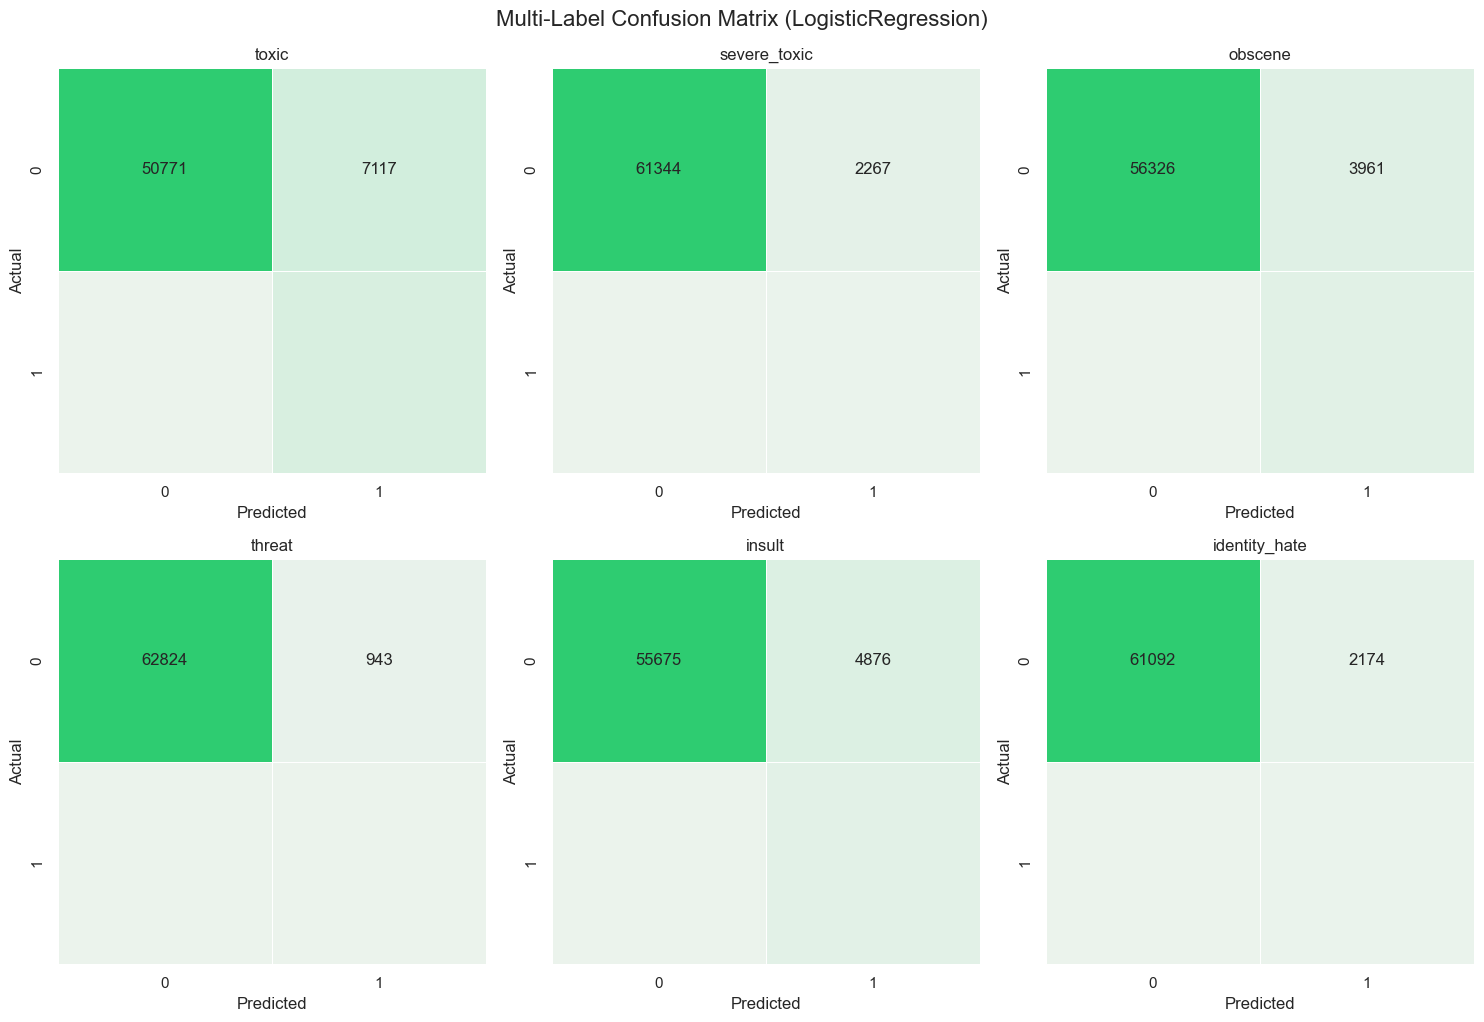

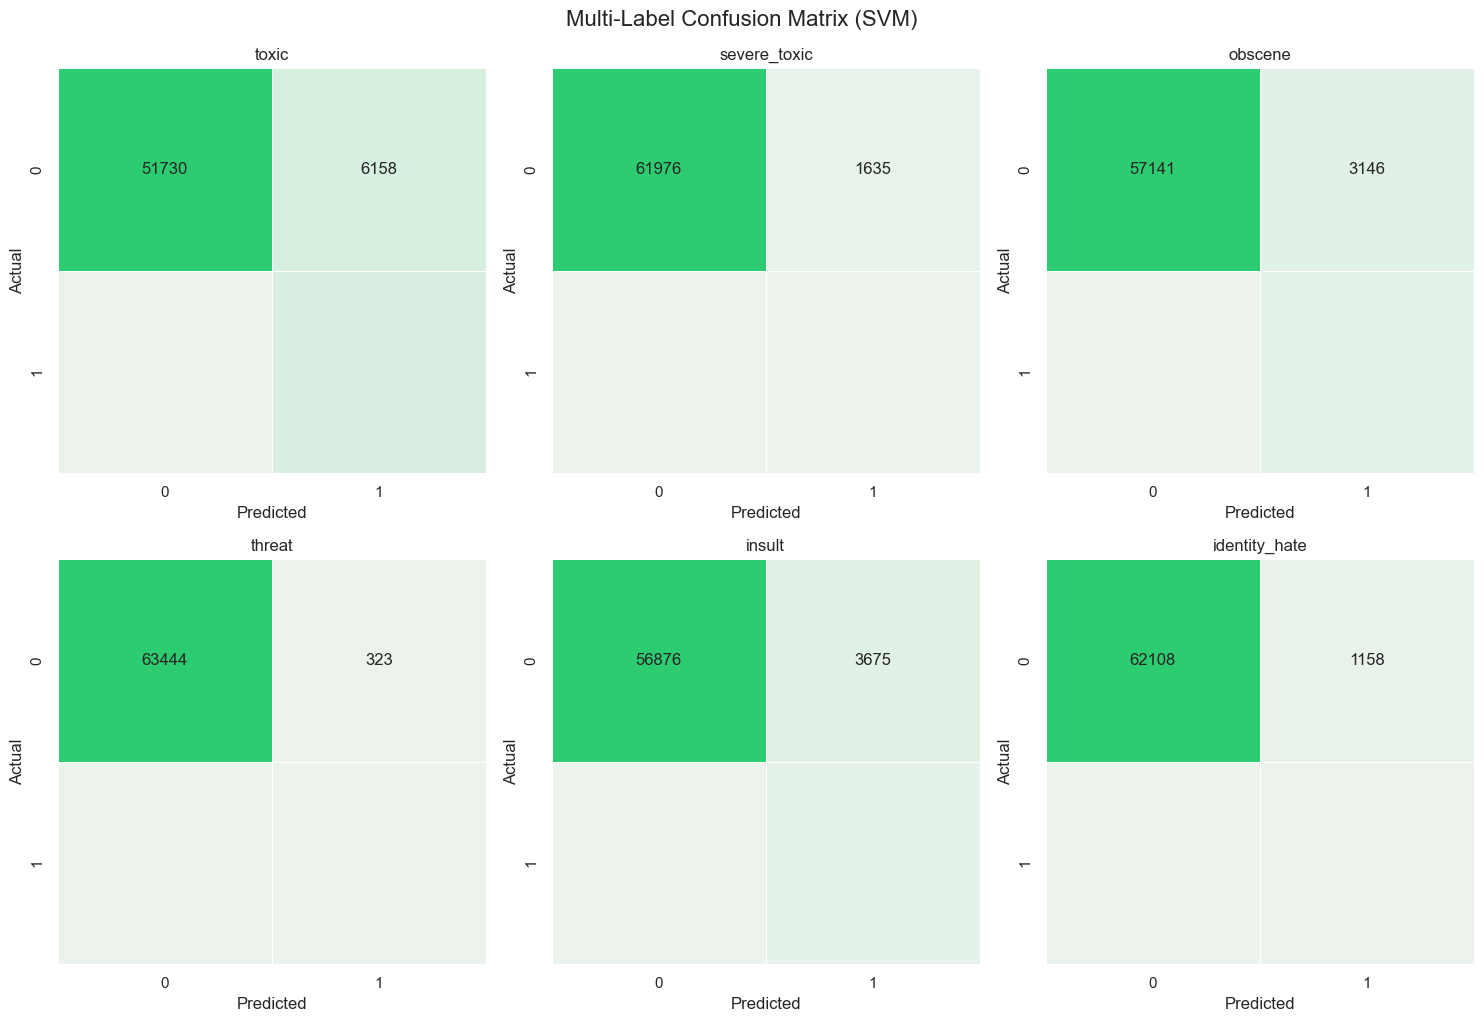

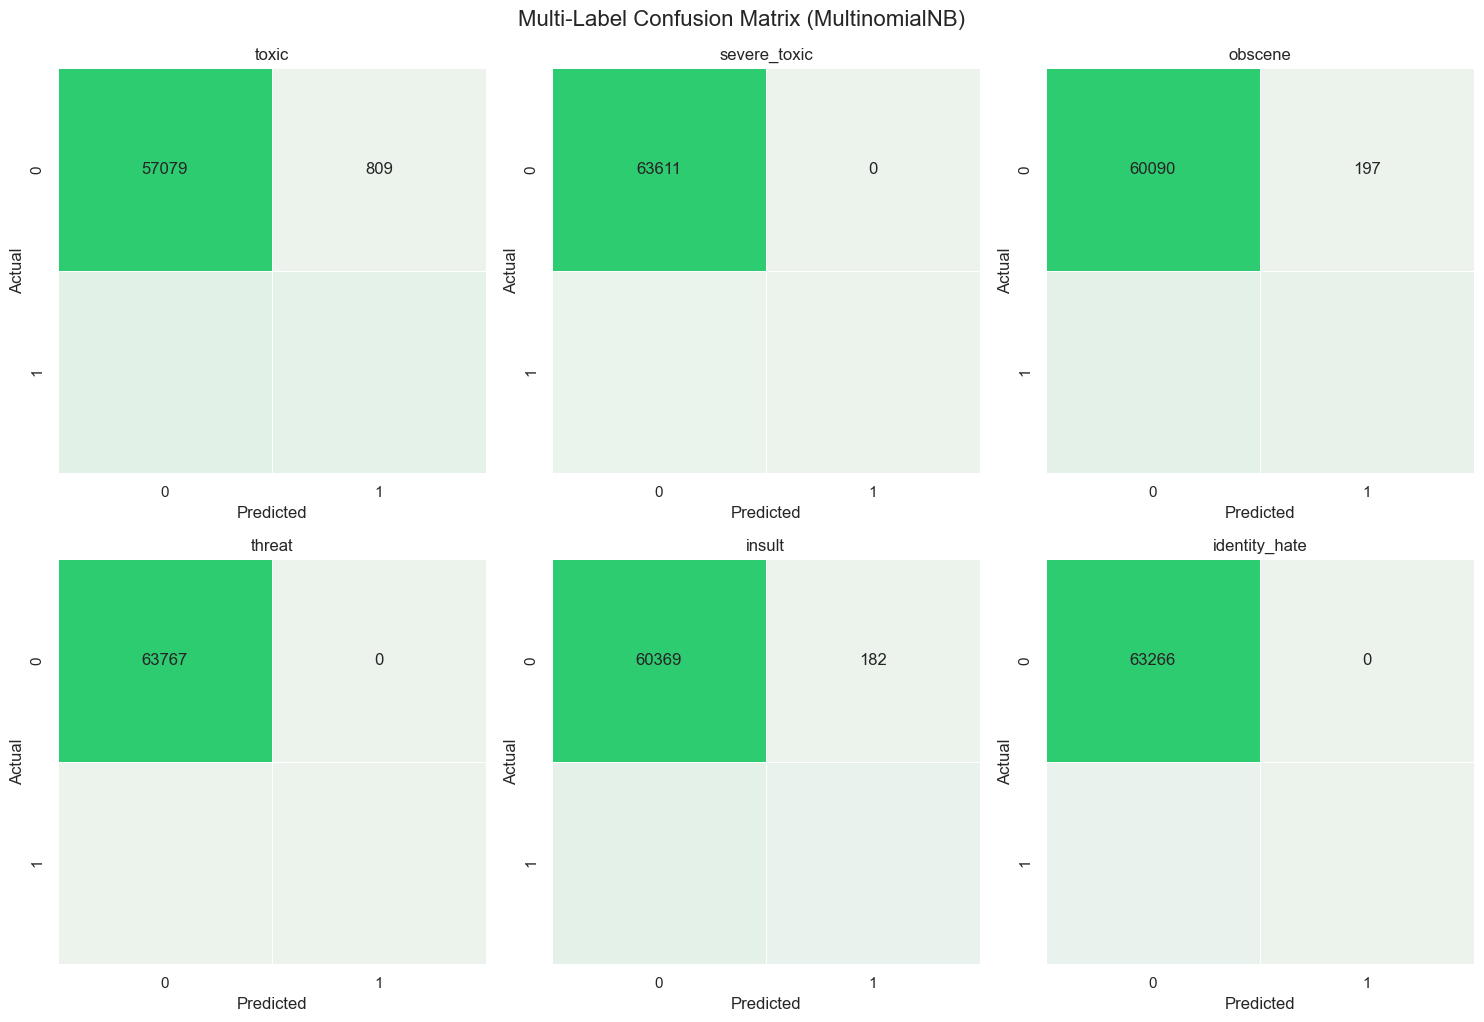

In [26]:
logistic_regression = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=0)
svm = LinearSVC(class_weight='balanced', max_iter=1000, random_state=0)
multinomial_nb = MultinomialNB()

classifiers = {
    'LogisticRegression': MultiOutputClassifier(logistic_regression),
    'SVM': MultiOutputClassifier(svm),
    'MultinomialNB': MultiOutputClassifier(multinomial_nb),
}

metrics = []
class_reports = {}
confusion_matrices = {}

for key, classifier in classifiers.items():
    evaluator = ClassifierEvaluator(X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf, class_labels)
    out_dict, class_report, confusion_matrix = evaluator.evaluate_and_visualize_classifier(classifier, key)
    
    metrics.append(out_dict)
    class_reports[key] = class_report
    confusion_matrices[key] = confusion_matrix

In [27]:
metrics_tfidf = pd.DataFrame(metrics)
print(metrics_tfidf)

                model  accuracy  precision    recall        f1   auc_roc
0  LogisticRegression  0.806840   0.293971  0.867374  0.423207  0.904190
1                 SVM  0.821673   0.342036  0.729323  0.456243  0.842301
2       MultinomialNB  0.902607   0.742684  0.174760  0.243638  0.585693


### Multi-Output Classification with Word2Vec

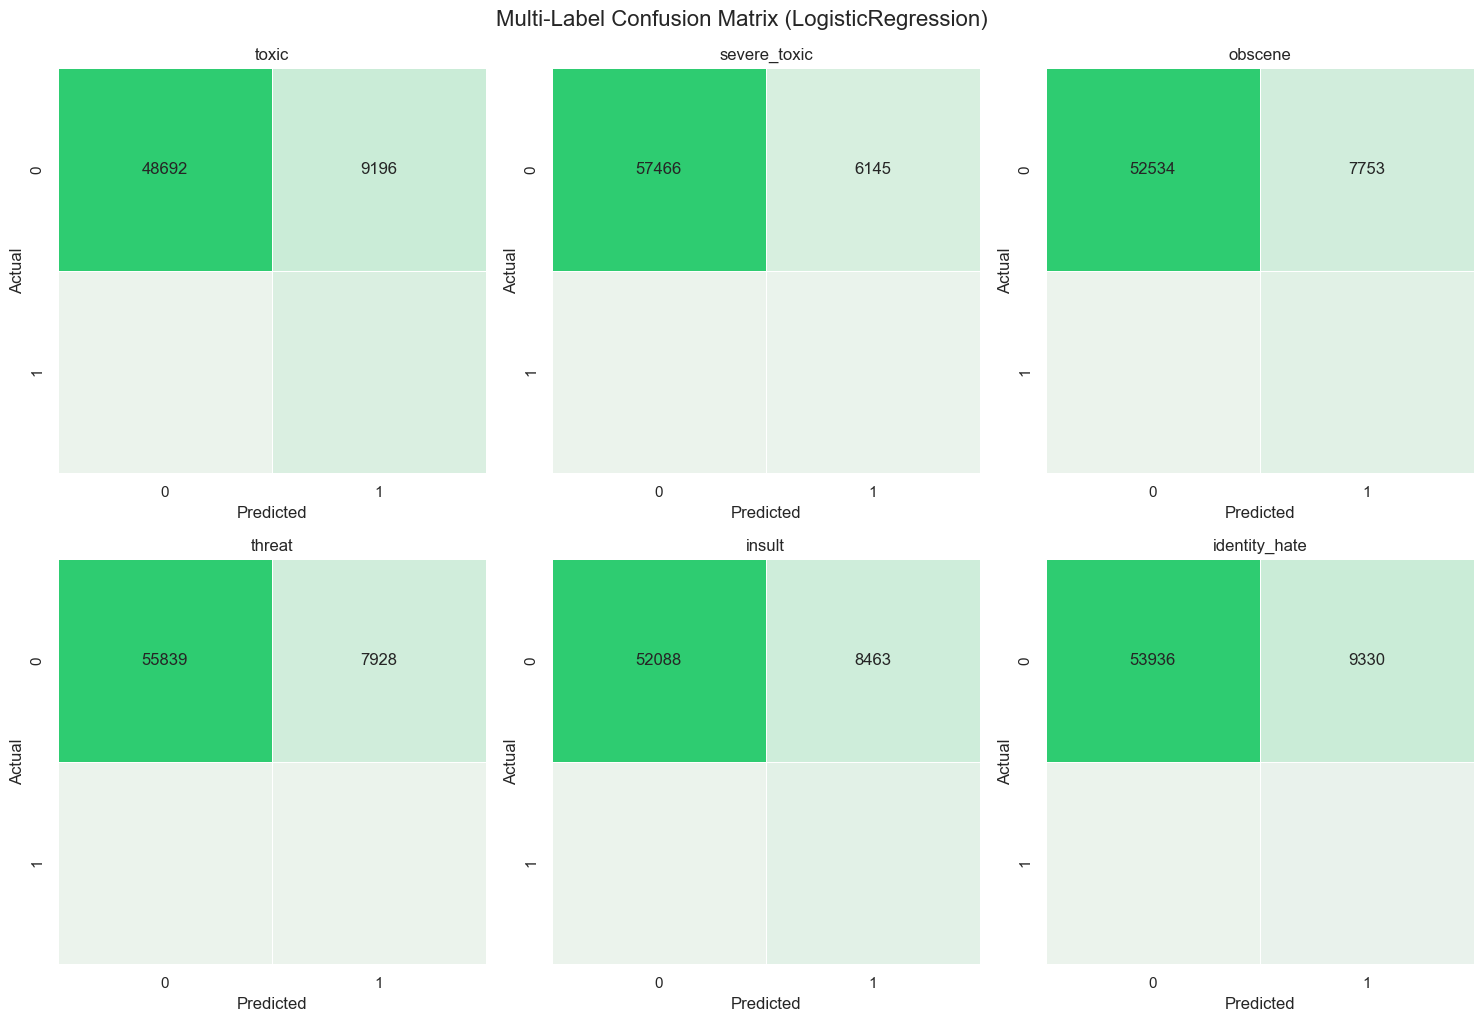

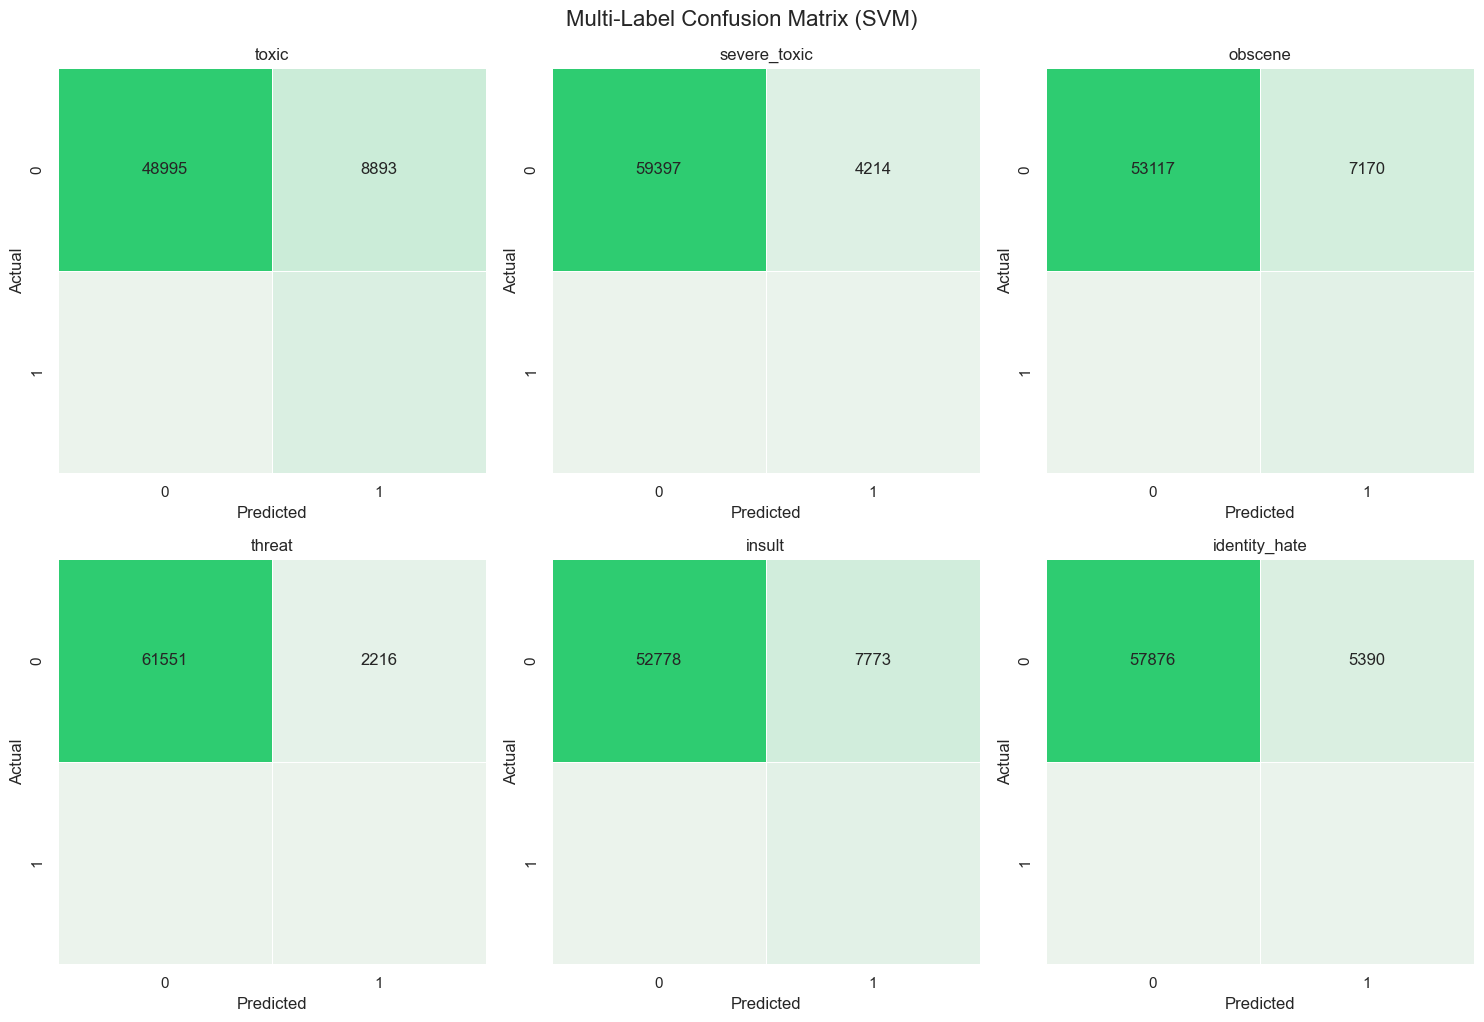

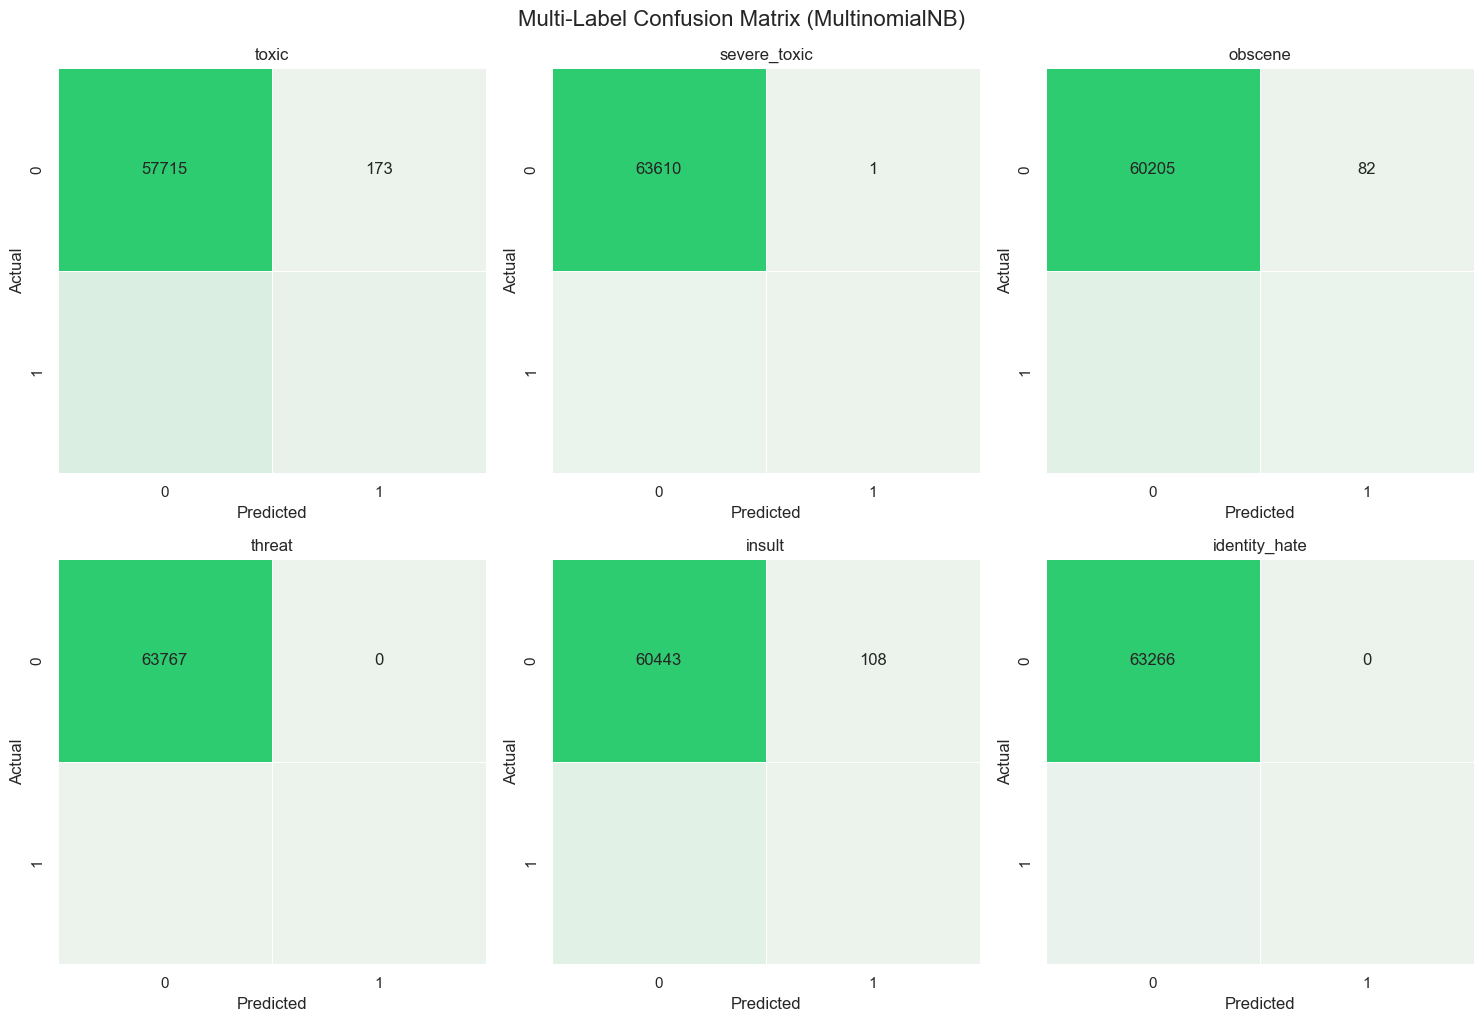

In [37]:
logistic_regression = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=0)
svm = LinearSVC(class_weight='balanced', max_iter=1000, random_state=0)
multinomial_nb = MultinomialNB()

classifiers = {
    'LogisticRegression': MultiOutputClassifier(logistic_regression),
    'SVM': MultiOutputClassifier(svm),
    'MultinomialNB': MultiOutputClassifier(multinomial_nb),
}

metrics = []
class_reports = {}
confusion_matrices = {}

for key, classifier in classifiers.items():
    evaluator = ClassifierEvaluator(X_train_word2vec, y_train_word2vec, X_test_word2vec, y_test_word2vec, class_labels)
    out_dict, class_report, confusion_matrix = evaluator.evaluate_and_visualize_classifier(classifier, key)
    
    metrics.append(out_dict)
    class_reports[key] = class_report
    confusion_matrices[key] = confusion_matrix

In [38]:
metrics_word2vec = pd.DataFrame(metrics)
print(metrics_word2vec)

                model  accuracy  precision    recall        f1   auc_roc
0  LogisticRegression  0.744662   0.176170  0.894948  0.269331  0.881171
1                 SVM  0.771515   0.197226  0.836199  0.301364  0.869173
2       MultinomialNB  0.903248   0.479783  0.056898  0.099238  0.527937


---
## Section 5. Conclusion

In conclusion, the evaluation of hate speech detection models based on various metrics revealed distinct performance characteristics:

- Accuracy: Multinomial Naive Bayes exhibited the highest accuracy (90.26%).
- Precision: Multinomial Naive Bayes also demonstrated the highest precision (74.27%).
- Recall: Logistic Regression outperformed with the highest recall (86.74%).
- F1 Score: Logistic Regression achieved the highest F1 score (42.32%).
- AUC-ROC: Logistic Regression topped the charts with the highest AUC-ROC (90.42%).

These results underscore the influence of the chosen feature extraction method on classification performance. The TF-IDF method consistently performed well across all three classifiers, yielding commendable accuracy, F1-score, recall, precision, and AUC. Conversely, Word Embeddings displayed slightly lower performance across metrics.

These findings imply that the selection of the appropriate feature extraction method significantly impacts classification accuracy and the models' ability to discern underlying patterns in the data. In the context of hate speech classification, the analysis suggests that semantic understanding between text might not be as critical. Instead, focusing on individual words could be more effective. 

It's also worth noting an exploration of ensemble methods between various machine learning models or delving into deep learning models may offer improved success.

Logistic Regression emerges as a strong candidate, boasting a balanced blend of precision and recall, along with a high AUC-ROC. SVM also proves noteworthy, excelling in accuracy, precision, and recall. Multinomial Naive Bayes, while exhibiting high accuracy and precision, might be more suitable when minimizing false positives is imperative.

Considering the inherent trade-offs in hate speech detection, Logistic Regression stands out as a well-balanced model for this specific context.